In [1]:
%pip install sklearn
%pip install scikit-learn
%pip install matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import json

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

Get all the real tags and the predictions

In [25]:
lang = "English"
ruta_archivo = f"output/{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
for elemento in elementos:
    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))


3


In [26]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.9635336414997432

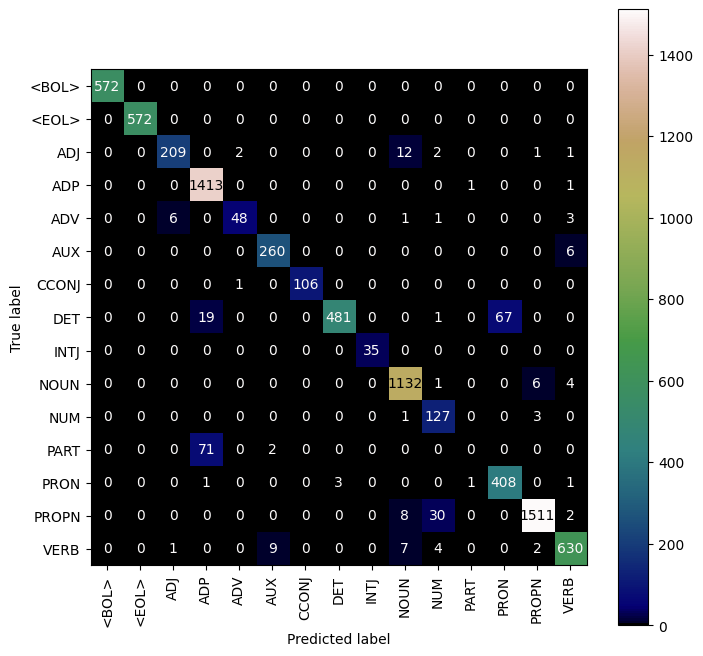

In [27]:
#create the confusion matrix
tags_set = sorted(set(all_predictions))
cm=confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()